# Semantic Variation Study

## Functions and Libraries

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt

/Users/alanyang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## BERTweet

In [2]:
# Load TweetBERT for embedding
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")

/Users/alanyang/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
/Users/alanyang/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

## Analysis

In [3]:
def calculate_semantic_variation(data, gen_title, model, tokenizer):
  topics = data['prompt'].unique()
  variation_scores = {}

  for topic in topics:
    print(f"Processing topic: {topic}")  # Print the topic being processed
    topic_data = data[data['prompt'] == topic][gen_title].tolist()
    inputs = tokenizer(topic_data, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
      outputs = model(**inputs)
      embeddings = outputs.last_hidden_state.mean(dim=1)

    cosine_sim = torch.nn.functional.cosine_similarity
    n = embeddings.size(0)
    pairwise_similarities = [
            cosine_sim(embeddings[i], embeddings[j], dim=0).item()
            for i in range(n) for j in range(i + 1, n)
            ]

    # Calculate the Variation
    average_similarity = np.mean(pairwise_similarities)
    variation_scores[topic] = 1 - average_similarity

  return variation_scores

In [18]:
# 'human_baseline', 'Gemini', 'Phi-14B', 'Phi-Tweet'
models = [
    {
        "model": "human_baseline",
        "file": "../eval/human_tweets_baseline.csv",
        "generation_title": "human tweets"
    },{
        "model": "Gemini",
        "file": "../eval/gemini_baseline.csv",
        "generation_title": "human tweets"
    },{
        "model": "Phi-14B",
        "file": "../eval/14B_3shots_real.csv",
        "generation_title": "microsoft/Phi-3-medium-4k-instruct"
    },{
        "model": "Phi-Tweet",
        "file": "../eval/100k_3_shots_post_real.csv",
        "generation_title": "AlanYky/phi-3.5_tweets_instruct"
    },{
        "model": "Phi-Tweet-RAG",
        "file": "../eval/100k_3shots_rag_post_real.csv",
        "generation_title": "AlanYky/phi-3.5_tweets_instruct"
    },
]

results = {}

In [20]:
for model_name in models:
    print(f"Processing Model: {model_name['model']}")
    data = pd.read_csv(model_name["file"])  # Assuming a CSV format
    results[model_name["model"]] = calculate_semantic_variation(
        data,
        model_name["generation_title"],
        model,
        tokenizer,
      )
    print("----------")

Processing Model: human_baseline
Processing topic: palestinian
Processing topic: donald
Processing topic: black friday
Processing topic: Tax Break
Processing topic: Ukraine
Processing topic: NBA
Processing topic: Taylor Swift
Processing topic: Mbappe
Processing topic: curry
Processing topic: las
Processing topic: montreal
Processing topic: squid
Processing topic: halloween
Processing topic: work
Processing topic: zero
Processing topic: Trudeau
Processing topic: trump
Processing topic: ChatGPT
Processing topic: Biden
Processing topic: LeBron
Processing topic: tech
Processing topic: SpaceX
Processing topic: AI
Processing topic: iphone
Processing topic: apple
----------
Processing Model: Gemini
Processing topic: Palestinian
Processing topic: Donald Trump 2025 President
Processing topic: Black Friday 2024
Processing topic: Tax Break Canada
Processing topic: Ukraine Russia war
Processing topic: NBA Final
Processing topic: Taylor Swift 2024
Processing topic: Mbappe
Processing topic: Stephen 

In [23]:
results

{'human_baseline': {'palestinian': 0.3076130353742176,
  'donald': 0.27009369929631555,
  'black friday': 0.33944667610857227,
  'Tax Break': 0.2879903005229102,
  'Ukraine': 0.3214024580187268,
  'NBA': 0.3777848194042842,
  'Taylor Swift': 0.3612774196598265,
  'Mbappe': 0.278171753221088,
  'curry': 0.36300954487588666,
  'las': 0.3146516147587034,
  'montreal': 0.2617329544491238,
  'squid': 0.2120027363300323,
  'halloween': 0.2888292259640164,
  'work': 0.3310419003168742,
  'zero': 0.32033544513914325,
  'Trudeau': 0.2766246752606498,
  'trump': 0.31175272001160514,
  'ChatGPT': 0.27128916051652696,
  'Biden': 0.30520274175537954,
  'LeBron': 0.3607580496205224,
  'tech': 0.3408949964576298,
  'SpaceX': 0.3250372389952342,
  'AI': 0.2755114303694831,
  'iphone': 0.3182531674702962,
  'apple': 0.3820658975177341},
 'Gemini': {'Palestinian': 0.1971556703249614,
  'Donald Trump 2025 President': 0.05019457207785716,
  'Black Friday 2024': 0.16463080247243245,
  'Tax Break Canada': 0

In [24]:
# Aggregate Results
aggregate_results = {
    model: {
        "mean_variation": np.mean(list(scores.values())),
        "std_variation": np.std(list(scores.values()))
    }
    for model, scores in results.items()
}

In [25]:
aggregate_results

{'human_baseline': {'mean_variation': 0.3121109464565913,
  'std_variation': 0.039907268407494104},
 'Gemini': {'mean_variation': 0.16266254101859196,
  'std_variation': 0.054095804743131616},
 'Phi-14B': {'mean_variation': 0.14747765594058568,
  'std_variation': 0.04132525708431618},
 'Phi-Tweet': {'mean_variation': 0.21425606899791294,
  'std_variation': 0.024075611172246904},
 'Phi-Tweet-RAG': {'mean_variation': 0.22585273816850449,
  'std_variation': 0.027750657937881677}}

In [26]:
models_names = [model['model'] for model in models]
models_names

['human_baseline', 'Gemini', 'Phi-14B', 'Phi-Tweet', 'Phi-Tweet-RAG']

                mean_variation  std_variation
human_baseline        0.312111       0.039907
Gemini                0.162663       0.054096
Phi-14B               0.147478       0.041325
Phi-Tweet             0.214256       0.024076
Phi-Tweet-RAG         0.225853       0.027751


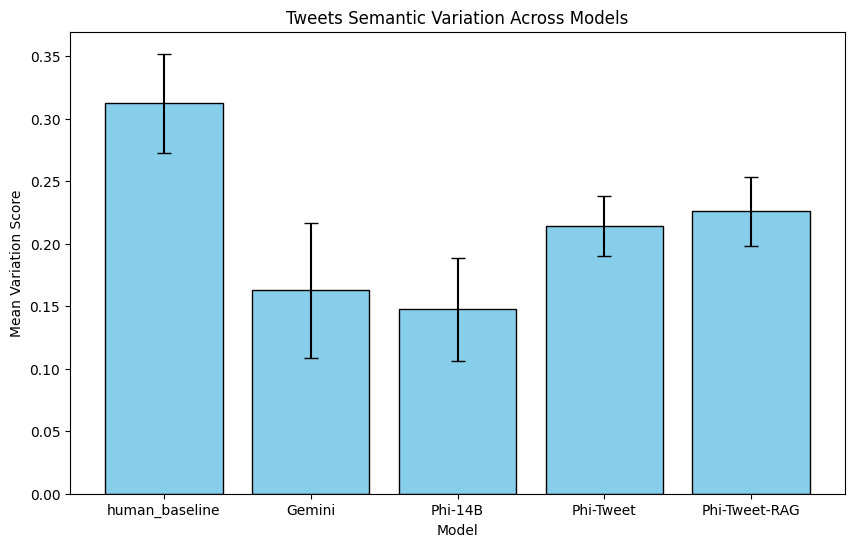

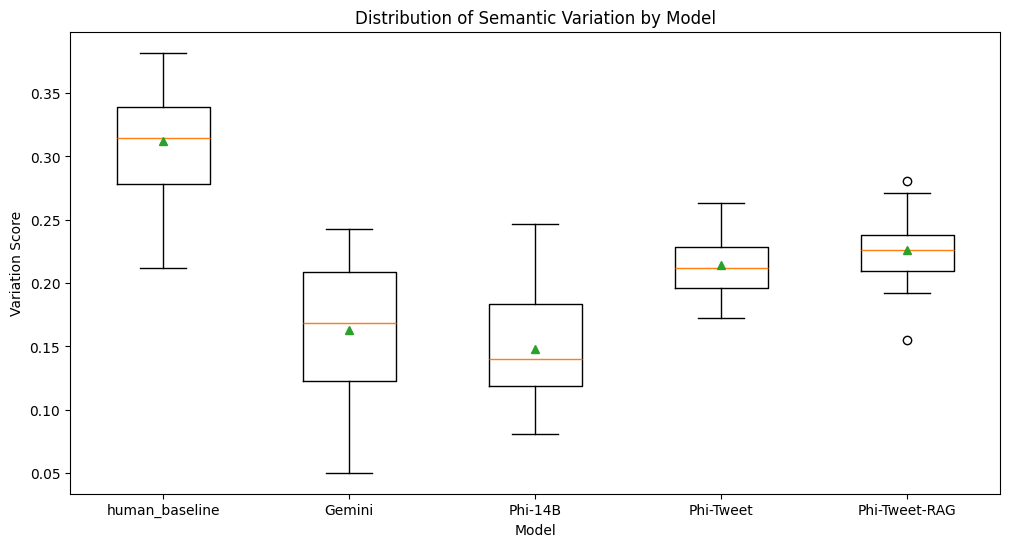

In [27]:
# Display Aggregate Results
print(pd.DataFrame(aggregate_results).T)

# Visualization: Bar Chart
plt.figure(figsize=(10, 6))
means = [aggregate_results[model]['mean_variation'] for model in models_names]
stds = [aggregate_results[model]['std_variation'] for model in models_names]
plt.bar(models_names, means, yerr=stds, capsize=5, color='skyblue', edgecolor='black')
plt.title("Tweets Semantic Variation Across Models")
plt.ylabel("Mean Variation Score")
plt.xlabel("Model")
plt.show()

# Visualization: Box Plot
all_variations = [list(scores.values()) for scores in results.values()]
plt.figure(figsize=(12, 6))
plt.boxplot(all_variations, labels=models_names, showmeans=True)
plt.title("Distribution of Semantic Variation by Model")
plt.ylabel("Variation Score")
plt.xlabel("Model")
plt.show()

### Higher Variation = Higher Creativity + More Diverse -> Human-Like Tweets

- Moderate Semantic Variation: Phi-Tweet achieves a mean variation of 0.214, closer to human-like diversity compared to other models (Gemini: 0.163, Phi-14B: 0.147), but still significantly below the human baseline (0.312).

- Consistency Across Topics: Phi-Tweet has the lowest standard deviation (0.024), indicating consistent performance across topics, though with less variation than humans.

- Room for Improvement: While Phi-Tweet outperforms Gemini and Phi-14B in diversity, it still lacks the creativity and semantic richness of human-generated tweets.

